<a href="https://colab.research.google.com/github/JanMeow/ML-cases/blob/main/0817_SAM_Perspective_Adjustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Path Set up

In [61]:
img_0 = "1qPYq5wf1pE72mN5meuBU6GRatGd6lz78"
img_1 = "1pC3AbQwWg2Ak0Jq1zKGAukIH-1sMViRK"
img_2 = "1uo8C7CrxglnsglbvW_riFrAQiAzbTsWG"
img_3 = "1RqCVsiY0oGUZ0zFUMxG5MyyZgmH7wNJU"

mask_0 = "1wS6o9dar-kaYHHWNH_aOaaQyDpR50RwA"
mask_1 = "1CIvPl0smPgpREoNwiZtodvVGLLSbq8Tf"
mask_2 = "1TfmxxFLD3voLeYtLVomkOoU8o0yy05dx"
mask_3 = "1Mx3ZibAxoF4HcLyYS7zMyWNxMSzn8-vJ"

!gdown --id $img_3 --output window.jpg
!gdown --id $mask_3 --output window_mask.jpg
!gdown --id $img_0 --output window_test.jpg

train_img = "window.jpg"
train_mask = "window_mask.jpg"
test_img = "window_test.jpg"

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RqCVsiY0oGUZ0zFUMxG5MyyZgmH7wNJU
To: /content/window.jpg
100% 28.9k/28.9k [00:00<00:00, 80.8MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Mx3ZibAxoF4HcLyYS7zMyWNxMSzn8-vJ
To: /content/window_mask.jpg
100% 7.43k/7.43k [00:00<00:00, 23.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com

## Installing PerSAM

In [62]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


##Load Model

In [63]:
from transformers import AutoProcessor, SamModel
# from transformers import PerSamModel

processor = AutoProcessor.from_pretrained("facebook/sam-vit-huge")
# model = PerSamModel.from_pretrained("facebook/sam-vit-huge")
model = SamModel.from_pretrained("facebook/sam-vit-huge")

##Load Reference Image and mask

In [102]:
from pathlib import Path
train_img = Path('/content/window_mask.jpg')
original_img = Path('/content/window.jpg')

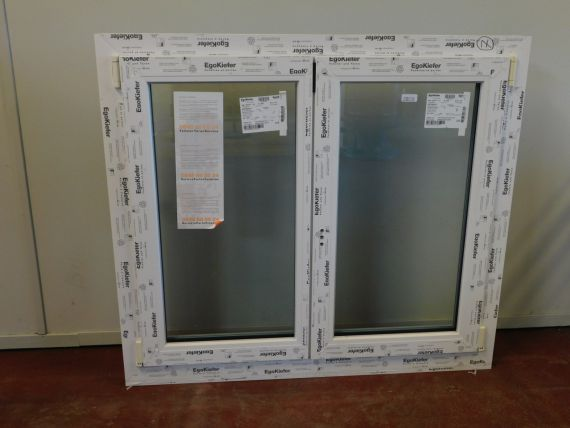

In [106]:
from PIL import Image

original_img = Image.open(original_img).convert("RGB")
original_img

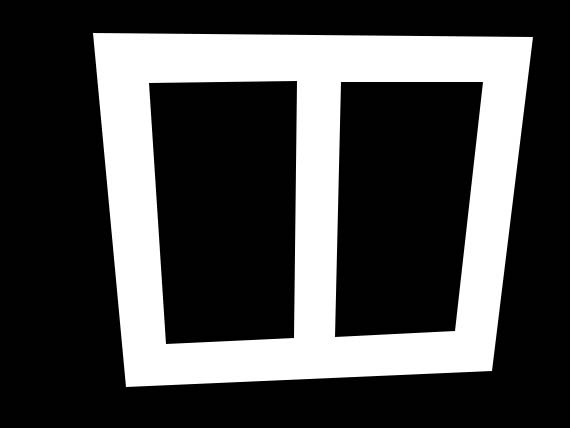

In [105]:
from huggingface_hub import hf_hub_download
from PIL import Image

ref_image = Image.open(train_img).convert("RGB")
ref_image

In [66]:
from PIL import Image
import numpy as np

numpy_array = np.array(ref_image)
print(numpy_array.shape)

(428, 570, 3)


In [67]:
numpy_array[0,0,:]

array([1, 1, 1], dtype=uint8)

In [68]:
crop = np.full_like(a=numpy_array, fill_value = 1,dtype= int)

In [69]:
mismatch_mask = numpy_array[...,-1] != crop[...,-1]
mismatched_pixel = np.argwhere(mismatch_mask)
print(mismatched_pixel)

[[ 32  88]
 [ 32  89]
 [ 32  90]
 ...
 [391 197]
 [391 198]
 [391 199]]


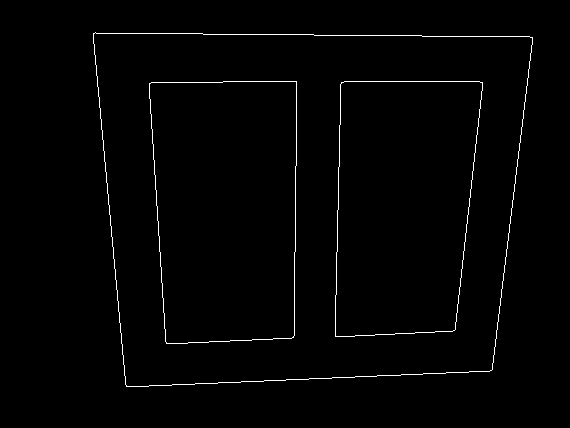

In [70]:
import cv2
from google.colab.patches import cv2_imshow
#convert to grayscale
img_gray =cv2.cvtColor(numpy_array, cv2.COLOR_BGR2GRAY)
#Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3),0)

# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
cv2_imshow(edges)

In [71]:
edges.shape

(428, 570)

In [72]:
pixel = np.where(edges!=[0])
pixel

(array([ 32,  33,  33, ..., 386, 386, 386]),
 array([ 95,  93,  94, ..., 146, 147, 148]))

In [73]:
import numpy as np

coordinate_array = np.column_stack((pixel[1], pixel[0]))
coordinate_array

array([[ 95,  32],
       [ 93,  33],
       [ 94,  33],
       ...,
       [146, 386],
       [147, 386],
       [148, 386]])

In [74]:

# Find the minimum and maximum values of x and y coordinates
min_x = np.min(coordinate_array[:, 0])
max_x = np.max(coordinate_array[:, 0])
min_y = np.min(coordinate_array[:, 1])
max_y = np.max(coordinate_array[:, 1])

# Calculate the corners of the rectangle/square
# bottom_left = (min_x, min_y)
# bottom_right = (max_x, min_y)
# top_left = (min_x, max_y)
# top_right = (max_x, max_y)





top_left = (min_x, min_y)
top_right = (max_x, min_y)
bottom_left = (min_x, max_y)
bottom_right = (max_x, max_y)
# top_left = (min_x, min_y)
# top_right = (max_x, max_y)
# bottom_right = (max_x, min_y)
# bottom_left = (min_x, max_y)

# top_left = (min_x, max_y)
# top_right = (max_x, max_y)
# Print the corners
print("Top Left:", top_left)
print("Top Right:", top_right)
print("Bottom Left:", bottom_left)
print("Bottom Right:", bottom_right)

Top Left: (93, 32)
Top Right: (532, 32)
Bottom Left: (93, 386)
Bottom Right: (532, 386)


In [75]:
corner_coordinates = np.array([top_left, top_right, bottom_right, bottom_left])
corner_coordinates[:,0]

array([ 93, 532, 532,  93])

In [76]:
corner_coordinates

array([[ 93,  32],
       [532,  32],
       [532, 386],
       [ 93, 386]])

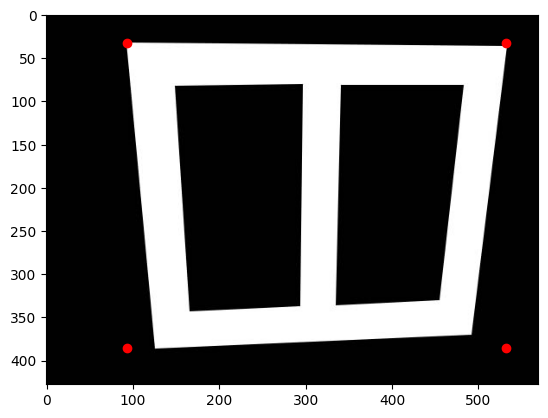

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


# Separate the x and y coordinates
x_coords = corner_coordinates[:, 0]
y_coords = corner_coordinates[:, 1]

# Plot the image
plt.imshow(ref_image)

# Plot the points as red dots
plt.scatter(x_coords, y_coords, color='red', marker='o')

# Show the plot
plt.show()

In [79]:
#Perspective transformation
import numpy
import cv2

#The corrindates of distorted window frame due to perspective
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)

# perspective_corners = np.array([bottom_left, bottom_right, top_right, top_left],  dtype=np.float32)
perspective_corners = np.array([bottom_left, bottom_right, top_right, top_left],  dtype=np.float32)


#Actual dimension
actual_width = 150
actual_height = 150

# Front elevation coordinates of the rectangle (4 corners)
front_elevation_corners = np.array([(0, 0), (actual_width, 0), (actual_width, actual_height), (0, actual_height)], dtype=np.float32)


#Transformation Matrix
transformation_matrix = cv2.getPerspectiveTransform(perspective_corners, front_elevation_corners)

In [80]:
transformed = cv2.perspectiveTransform(perspective_corners.reshape(-1, 1, 2), transformation_matrix).reshape(-1,2)
transformed

array([[ 0.0000000e+00,  0.0000000e+00],
       [ 1.5000000e+02,  0.0000000e+00],
       [ 1.5000000e+02,  1.5000000e+02],
       [-3.5527137e-15,  1.5000000e+02]], dtype=float32)

In [81]:
#Transform entire edge detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection

transformed_edges = cv2.perspectiveTransform(np.array(edges, dtype = np.float32).reshape(-1, 1, 2), transformation_matrix)
transformed_edges

array([[[-31.776766, 163.55933 ]],

       [[-31.776766, 163.55933 ]],

       [[-31.776766, 163.55933 ]],

       ...,

       [[-31.776766, 163.55933 ]],

       [[-31.776766, 163.55933 ]],

       [[-31.776766, 163.55933 ]]], dtype=float32)

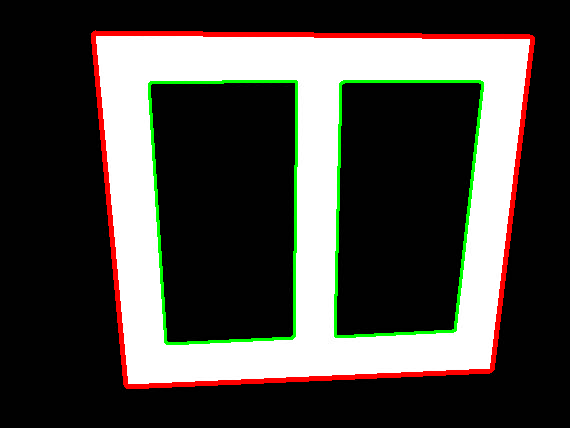

In [159]:
import cv2
import numpy as np

# Load the image
img_blur = cv2.GaussianBlur(img_gray, (3,3),0)
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
original_img = np.array(ref_image)

# Find external contours in the image
ex_contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
in_contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


# Convert the contours to the desired format
ex_vertices = []
in_vertices = []
for contour in ex_contours:
    vertices = contour.reshape(-1, 2).tolist()
    ex_vertices.append(vertices)

for contour in in_contours:
  vertices = contour.reshape(-1, 2).tolist()
  in_vertices.append(vertices)

# Draw contours on the original image
cv2.drawContours(original_img, in_contours, -1, (0, 255, 0), 2)
cv2.drawContours(original_img, ex_contours, -1, (0, 0, 255), 3)


# Display the image with contours
cv2_imshow(original_img)


In [115]:
def get_corners(vertices):

  coordinate_array = np.array(vertices).squeeze()

  min_x = np.min(coordinate_array[:, 0])
  max_x = np.max(coordinate_array[:, 0])
  min_y = np.min(coordinate_array[:, 1])
  max_y = np.max(coordinate_array[:, 1])

  top_left = (min_x, min_y)
  top_right = (max_x, min_y)
  bottom_left = (min_x, max_y)
  bottom_right = (max_x, max_y)

  return np.array([bottom_left, bottom_right, top_right, top_left],  dtype=np.float32)


get_corners(ex_vertices)

array([[ 93., 386.],
       [532., 386.],
       [532.,  32.],
       [ 93.,  32.]], dtype=float32)

In [164]:
np.array(in_vertices[0]).squeeze().shape

(88, 2)

In [167]:
in_corners = []
for i in range(len(in_vertices)):
  vertices = in_vertices[i]
  corners = get_corners(vertices)
  in_corners.append(corners)
in_corners

[array([[335., 336.],
        [482., 336.],
        [482.,  81.],
        [335.,  81.]], dtype=float32),
 array([[149., 343.],
        [296., 343.],
        [296.,  81.],
        [149.,  81.]], dtype=float32),
 array([[335., 336.],
        [482., 336.],
        [482.,  81.],
        [335.,  81.]], dtype=float32),
 array([[149., 343.],
        [296., 343.],
        [296.,  81.],
        [149.,  81.]], dtype=float32),
 array([[ 93., 386.],
        [532., 386.],
        [532.,  32.],
        [ 93.,  32.]], dtype=float32),
 array([[ 93., 386.],
        [532., 386.],
        [532.,  32.],
        [ 93.,  32.]], dtype=float32)]

In [ ]:
import cv2
import numpy as np

# Load the image
img_blur = cv2.GaussianBlur(img_gray, (3,3),0)
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
original_img = np.array(ref_image)

# Find external contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert the contours to the desired format
contour_vertices = []
for contour in contours:
    vertices = contour.reshape(-1, 2).tolist()
    contour_vertices.append(vertices)

# Draw contours on the original image
cv2.drawContours(original_img, contours, -1, (0, 0, 255), 2)

# Display the image with contours
cv2_imshow(original_img)


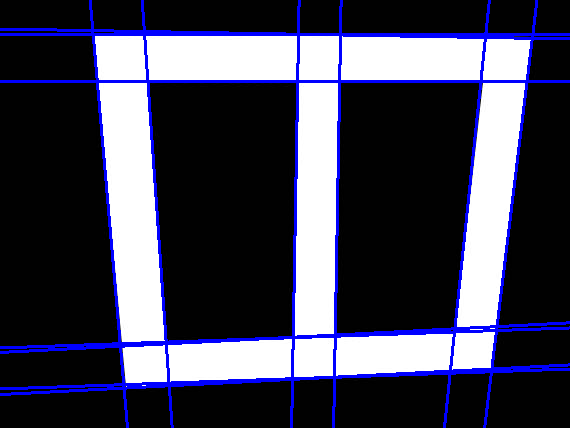

In [82]:
import cv2
import numpy as np

img_blur = cv2.GaussianBlur(img_gray, (3,3),0)
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)

numpy_array = np.array(ref_image)

lines = cv2.HoughLines(edges,1,np.pi/180,100)


for line in lines:
  rho, theta = line[0]
  a = np.cos(theta)
  b = np.sin(theta)

  x0 = a * rho
  y0 = b * rho
  x1 = int(x0 + 1000*(-b))
  y1 = int(y0 + 1000*(a))
  x2 = int(x0 - 1000*(-b))
  y2 = int(y0 - 1000*(a))

  cv2.line(numpy_array,(x1,y1),(x2,y2),(255,0,0),2)


cv2_imshow(numpy_array)

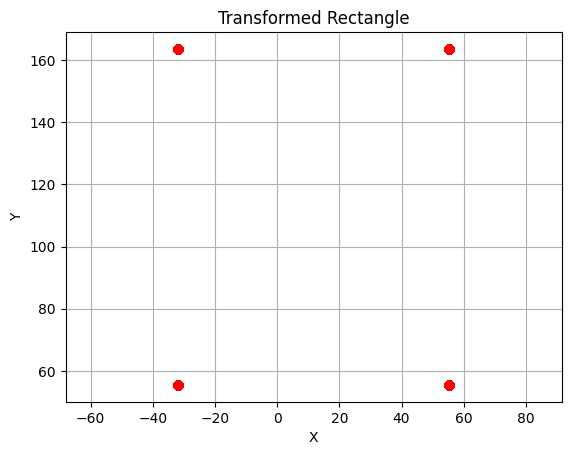

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Transformed coordinates of the rectangle
transformed_coordinates = transformed_edges.reshape(-1,2)
# Define the order of vertices to create the rectangle edges
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]

# Plot the transformed rectangle
plt.figure()
for edge in edges:
    plt.plot(transformed_coordinates[edge, 0], transformed_coordinates[edge, 1], 'b-')

plt.scatter(transformed_coordinates[:, 0], transformed_coordinates[:, 1], color='red', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Transformed Rectangle')
plt.grid()
plt.axis('equal')
plt.show()

In [84]:
# from huggingface_hub import hf_hub_download
# from PIL import Image

# ref_image = Image.open(train_img).convert("RGB")
# ref_image